<img src="https://pbs.twimg.com/media/FpBhWD2XsB0KS_X.jpg:large" style="width: 300px;" alt="SumerSports logo Image">

# Modeling Player Tracking Data with Transformers and Deep Learning
*Unlocking deeper football insights through advanced machine learning*

## Overview
This comprehensive notebook demonstrates the application of transformer models to NFL player tracking data, offering data scientists and sports analysts a modern approach to understanding the complex dynamics of football through sophisticated machine learning techniques. By leveraging state-of-the-art deep learning architectures, we aim to uncover hidden patterns and strategic insights from player movement data.

*Note: This notebook is intended as an educational resource to demonstrate transformer applications in sports analytics, not as a competitive entry for the Kaggle competition. Our goal is to provide a foundation for understanding and implementing these techniques.*

## Why Transformers?
Transformers represent a breakthrough in analyzing spatio-temporal sports data. These powerful models are particularly well-suited for player tracking analysis as they naturally handle variable player ordering, reduce the need for complex feature engineering, and excel at capturing intricate interactions between players. Their self-attention mechanism provides a natural framework for understanding how players influence and react to each other on the field.

## Contents
1. Data Preprocessing:
 Processing NFL tracking data into a suitable format and selecting relevant features. We'll cover data cleaning, normalization, and the creation of meaningful input sequences that capture the essence of player movements and game dynamics. Due to computational limitations, we process only a single week of data (week 1) for this notebook.

2. Model Implementation:
 Setting up the transformer architecture and training pipeline using modern deep learning frameworks. In this example we will train a model to predict the `offenseFormation` of the play, given a frame of data.

3. Analysis & Evaluation:
 Assessing model performance through evaluation metrics and confusion matrices. Despite training on less than a single week of data, the model is able to predict `offenseFormation` on a withheld test set at **~81% accuracy**

## Applications
While our focus centers on NFL data, the methodologies and techniques presented here extend far beyond football. These approaches can be adapted for analyzing player tracking data across various sports, opening new avenues for strategic analysis in basketball, soccer, hockey, and more.

## Contributing
This notebook represents a collaborative effort to advance the field of sports analytics. We actively encourage community participation through feedback, code contributions, and discussions about innovative approaches. By sharing knowledge and building upon each other's work, we can collectively push the boundaries of what's possible in sports analytics.


# Step 0: Add "sportstransformer-utils" utils via Kaggle Dataset
`File --> Add Input --> DataSets --> Search "SportsTransformer_utils" --> Add`


In [24]:
import sys
#sys.path.append('/kaggle/input/sportstransformer-utils')
import prep_data
import process_datasets
import models
import prep_data2025 as new_prep
import process_datasets2025 as new_process

# Explore the modeling target -> offenseFormation

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import pandas as pd

# Read the CSV
plays_df = pd.read_csv('bdb2023/plays.csv')

# Get value counts of offenseFormation
formation_counts = (plays_df['personnelLB']
    .value_counts()
    .sort_index()  # Sort alphabetically by formation name
    .to_frame()    # Convert to DataFrame for nicer printing
)
print(formation_counts)

# Get output dim. Number of unique formations
output_dim = plays_df['personnelLB'].nunique()

             count
personnelLB       
0                1
1              500
2             2908
3             2661
4             2331
5              154
6                3


# 1. Data Preprocessing

In [4]:
prep_data.main()
process_datasets.main()

Load players
Load plays
Load tracking
tracking_df rows: 7016306
Add features to tracking
Convert tracking to cartesian
Standardize play direction
Augment data by mirroring
Generate target - defFormation
Split train/test/val/none
Total set: 15050 plays, 637846 frames
Train set: 10536 plays, 448026 frames
Test set: 2256 plays, 95372 frames
Validation set: 2258 plays, 94448 frames
Train set: 10536 plays, 448026 frames
Creating dataset for model_type='transformer', split='test'...


Pre-computing feature transforms: 100%|██████████| 95372/95372 [03:16<00:00, 485.37it/s]


Took 4.1 mins
Creating dataset for model_type='transformer', split='val'...


Pre-computing feature transforms: 100%|██████████| 94448/94448 [03:14<00:00, 486.32it/s]


Took 4.0 mins
Creating dataset for model_type='transformer', split='train'...


Pre-computing feature transforms: 100%|██████████| 448026/448026 [14:52<00:00, 501.73it/s]


Took 18.7 mins
Creating dataset for model_type='transformer', split='none'...


Pre-computing feature transforms: 100%|██████████| 637846/637846 [22:15<00:00, 477.59it/s]


Took 27.7 mins


In [5]:
import torch
from torch.utils.data import DataLoader
from process_datasets import load_datasets

# Load preprocessed datasets
train_dataset = load_datasets(model_type='transformer', split='train')#transformer
val_dataset = load_datasets(model_type='transformer', split='val')
test_dataset = load_datasets(model_type='transformer', split='test')

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3)

# Print feature and target shapes from DataLoaders
for batch in train_loader:
    features, targets = batch
    print("Train features shape:", features.shape)
    print("Train targets shape:", targets.shape)
    break

Train features shape: torch.Size([64, 22, 5])
Train targets shape: torch.Size([64, 7])


# 2. Model Implemenation

In [6]:
from models import SportsTransformerLitModel

# Model parameters
feature_len = 5  # Adjust this as needed based on input data
model_dim = 64  # Dimension of transformer model (adjustable)
num_layers = 4  # Number of transformer layers (adjustable)
dropout = 0.01
learning_rate = 1e-3
batch_size = 64
output_dim = plays_df['personnelLB'].nunique()

# Initialize the model
model = SportsTransformerLitModel(
    feature_len=feature_len,
    batch_size=batch_size,
    model_dim=model_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout=dropout,
    learning_rate=learning_rate,
)

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

# Define checkpointing to save the best model
checkpoint_callback = ModelCheckpoint(
   dirpath=Path("checkpoints/"),
   filename="best-checkpoint",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

# Define early stopping
early_stop_callback = EarlyStopping(
   monitor="val_loss",
   min_delta=0.01,  # Minimum change in monitored value to qualify as an improvement
   patience=3,      # Number of epochs with no improvement after which training will be stopped
   verbose=True,
   mode="min"
)

# Initialize the trainer
trainer = Trainer(
   max_epochs=20,  # Adjust the number of epochs
   accelerator="gpu",  # Use 'gpu' if CUDA is available, otherwise use 'cpu'
   devices=1,
   callbacks=[checkpoint_callback, early_stop_callback],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [8]:
# Start training
trainer.fit(model, train_loader, val_loader)

d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\NFL\BDB25\BDB25\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode  | In sizes    | Out sizes
--------------------------------------------------------------------------------
0 | model   | SportsTransformer | 205 K  | train | [64, 22, 5] | [64, 7]  
1 | loss_fn | BCEWithLogitsLoss | 0      | train | ?           | ?        
--------------------------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.823     Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 7001/7001 [07:50<00:00, 14.87it/s, v_num=21, val_loss=0.308, train_loss=0.314]

Metric val_loss improved. New best score: 0.308
Epoch 0, global step 7001: 'val_loss' reached 0.30804 (best 0.30804), saving model to 'D:\\NFL\\BDB25\\BDB25\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 7001/7001 [09:21<00:00, 12.46it/s, v_num=21, val_loss=0.307, train_loss=0.310] 

Epoch 1, global step 14002: 'val_loss' reached 0.30746 (best 0.30746), saving model to 'D:\\NFL\\BDB25\\BDB25\\checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 2: 100%|██████████| 7001/7001 [3:10:53<00:00,  0.61it/s, v_num=21, val_loss=0.308, train_loss=0.309]  

Epoch 2, global step 21003: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 7001/7001 [09:43<00:00, 11.99it/s, v_num=21, val_loss=0.307, train_loss=0.308]  

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.308. Signaling Trainer to stop.
Epoch 3, global step 28004: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 7001/7001 [09:43<00:00, 11.99it/s, v_num=21, val_loss=0.307, train_loss=0.308]


# 3. Analysis and Evaluation

In [9]:
# Inference on test data
predictions = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 1491/1491 [00:21<00:00, 70.54it/s]


In [10]:
# Concatenate predictions into a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Assuming predictions are logits for a multi-class problem
predicted_labels = torch.argmax(predictions_tensor, dim=1)

In [11]:
import numpy as np

# Extract true labels from the test_loader
y_true = torch.cat([y for _, y in test_loader], dim=0)

# Convert tensors to numpy arrays if needed for sklearn functions
y_true_np = np.argmax(y_true.cpu().numpy(), axis=-1)
predicted_labels_np = predicted_labels.cpu().numpy()

print("y_true shape:", y_true_np.shape)
print("Predicted labels shape:", predicted_labels_np.shape)

y_true shape: (95372,)
Predicted labels shape: (95372,)


In [12]:
# Attach predictions to metadata
df_test = pd.read_parquet('bdb2023/test_features.parquet')

df_test_grouped = (df_test
   .groupby(['gameId', 'playId', 'frameId', 'mirrored'])#'frameType', 
   .agg('last')  # or .last() depending on pandas version
   .sort_values(['gameId', 'playId', 'frameId', 'mirrored'])#'frameType', 
)
df_test_grouped['y_pred'] = predicted_labels_np
df_test_grouped['y_true'] = y_true_np

# Filter to ball_snap event for evaluation
df_test_grouped = df_test_grouped[df_test_grouped.event == "ball_snap"]
predicted_labels_np = df_test_grouped['y_pred']
y_true_np = df_test_grouped['y_true']

print(len(y_true_np), len(predicted_labels_np))

2252 2252


Unique values in true labels: [1 2 3 4 5]
Unique values in predicted labels: [2 3 4]
Formation enum values: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Accuracy: 0.3748
Precision (weighted): 0.3430
Recall (weighted): 0.3748
F1 Score (weighted): 0.3410


d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


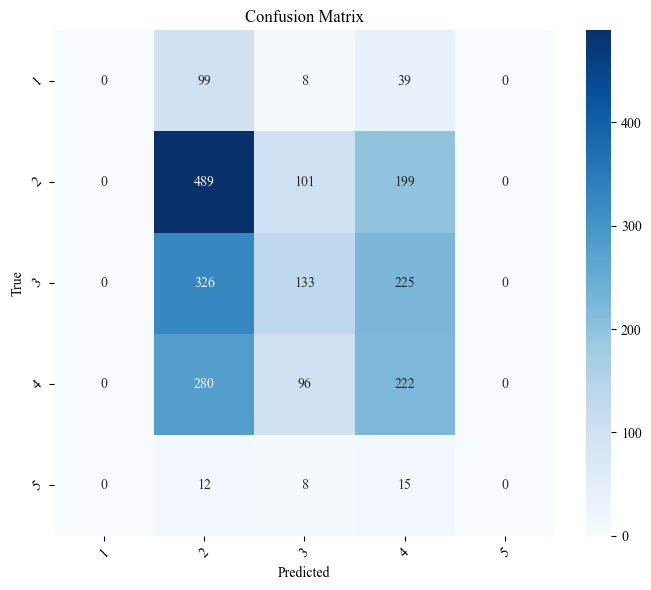


Per-class Metrics:

1:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

2:
Precision: 0.4055
Recall: 0.6198
F1-score: 0.4902

3:
Precision: 0.3844
Recall: 0.1944
F1-score: 0.2583

4:
Precision: 0.3171
Recall: 0.3712
F1-score: 0.3421

5:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

# Get class labels from FORMATION_ENUM and sort alphabetically
formation_labels = sorted(list(process_datasets.FORMATION_ENUM.keys()))

# Print unique values to debug
print("Unique values in true labels:", np.unique(y_true_np))
print("Unique values in predicted labels:", np.unique(predicted_labels_np))
print("Formation enum values:", process_datasets.FORMATION_ENUM)

# Calculate metrics using labels parameter to specify valid classes
accuracy = accuracy_score(y_true_np, predicted_labels_np)
precision = precision_score(y_true_np, predicted_labels_np, average='weighted', 
                         labels=np.unique(y_true_np))
recall = recall_score(y_true_np, predicted_labels_np, average='weighted',
                    labels=np.unique(y_true_np))
f1 = f1_score(y_true_np, predicted_labels_np, average='weighted',
             labels=np.unique(y_true_np))

# Create confusion matrix only for classes that appear in the data
present_classes = sorted(list(set(np.unique(y_true_np)) | set(np.unique(predicted_labels_np))))
conf_matrix = confusion_matrix(y_true_np, predicted_labels_np, 
                            labels=present_classes)

# Get labels for present classes
present_labels = [formation_labels[i] for i in present_classes]

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Plot confusion matrix with labels for present classes
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, 
          annot=True, 
          fmt='d', 
          cmap='Blues',
          xticklabels=present_labels,
          yticklabels=present_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print per-class metrics only for present classes
print("\nPer-class Metrics:")
for i, formation in zip(present_classes, present_labels):
  class_precision = precision_score(y_true_np, predicted_labels_np, labels=[i], average=None)[0]
  class_recall = recall_score(y_true_np, predicted_labels_np, labels=[i], average=None)[0]
  class_f1 = f1_score(y_true_np, predicted_labels_np, labels=[i], average=None)[0]
  print(f"\n{formation}:")
  print(f"Precision: {class_precision:.4f}")
  print(f"Recall: {class_recall:.4f}")
  print(f"F1-score: {class_f1:.4f}")

In [25]:
new_prep.main()


Load players
Load plays
Load tracking
tracking_df rows: 6795800
Add features to tracking
Convert tracking to cartesian
Standardize play direction
Augment data by mirroring
Generate target - defFormation
Split train/test/val/none
Total set: 3904 plays, 617800 frames
Train set: 2734 plays, 429586 frames
Test set: 584 plays, 93424 frames
Validation set: 586 plays, 94790 frames
None set: 3904 plays, 617800 frames


In [26]:
new_process.main()

Creating dataset for model_type='transformer', split='test'...


Pre-computing feature transforms: 100%|██████████| 93424/93424 [04:12<00:00, 369.39it/s]


Took 5.0 mins
Creating dataset for model_type='transformer', split='val'...


Pre-computing feature transforms: 100%|██████████| 94790/94790 [03:35<00:00, 439.74it/s]


Took 4.4 mins
Creating dataset for model_type='transformer', split='train'...


Pre-computing feature transforms: 100%|██████████| 429586/429586 [17:19<00:00, 413.28it/s]


Took 21.2 mins
Creating dataset for model_type='transformer', split='none'...


Pre-computing feature transforms: 100%|██████████| 617800/617800 [29:48<00:00, 345.38it/s]


Took 35.8 mins


In [27]:
bdb2025_dataset = new_process.load_datasets(model_type='transformer', split='none')

# Create DataLoader objects
batch_size = 64
bdb2025_loader = DataLoader(bdb2025_dataset, batch_size=batch_size, num_workers=3)

In [28]:
predictions = trainer.predict(model, bdb2025_loader)
predictions_tensor = torch.cat(predictions, dim=0)

# Assuming predictions are logits for a multi-class problem
predicted_labels = torch.argmax(predictions_tensor, dim=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\SoccerData\StatsBomb24\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 9654/9654 [02:22<00:00, 67.64it/s]


In [29]:
import numpy as np

# Extract true labels from the test_loader
y_true = torch.cat([y for _, y in bdb2025_loader], dim=0)

# Convert tensors to numpy arrays if needed for sklearn functions
y_true_np = np.argmax(y_true.cpu().numpy(), axis=-1)
predicted_labels_np = predicted_labels.cpu().numpy()

print("y_true shape:", y_true_np.shape)
print("Predicted labels shape:", predicted_labels_np.shape)

y_true shape: (617800,)
Predicted labels shape: (617800,)


In [30]:
df_week1 = pd.read_parquet('none_features.parquet')

df_week1_grouped = (df_week1
   .groupby(['gameId', 'playId', 'frameId', 'frameType', 'mirrored'])#
   .agg('last')  # or .last() depending on pandas version
   .sort_values(['gameId', 'playId', 'frameId', 'frameType', 'mirrored'])#'frameType', 
)
df_week1_grouped['y_pred'] = predicted_labels_np
df_week1_grouped['y_true'] = y_true_np

# Filter to ball_snap event for evaluation
df_week1_grouped = df_week1_grouped[df_week1_grouped.event == "ball_snap"]
predicted_labels_np = df_week1_grouped['y_pred']
y_true_np = df_week1_grouped['y_true']

print(len(y_true_np), len(predicted_labels_np))

3896 3896


In [32]:
df_week1_grouped.to_csv("week1_4_LB_plays.csv")